# Lecture 1

~~- Part 1: Qiskit Basic (10min)~~
    - ~~Basic Quantum Gates and Operations~~
    - ~~Exercise: Quantum State manipulating with the gates - Bell State~~
- Part 2: Tutorial with GHZ Circuit (30 min)
    - Compose 3-qubits GHZ quantum circuits
    - simulating them on various backends, and visualizing the results
- Part 3: Introduction of the Quantum Information Theory (30min)
    - Phase Kickback
    - the Deutsch Jozsa algorithm
- Exercise (20min):
    - explore easy physics model by using qiskit with assignment1

# Part 2: Tutorial with GHZ Circuit: Compose 3-qubits GHZ quantum circuits

With this tutorial, we will learn how to build a fully entangled three-qubit quantum circuit and how to run this circuit via the quantum backend.

In [3]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.visualization import *
from qiskit.quantum_info import state_fidelity

import numpy as np

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Magic function to render plots
%matplotlib inline

## step1: build a three-qubit GHZ state
Let's start to compose the [GHZ(Greenberger–Horne–Zeilinger) circuit](https://en.wikipedia.org/wiki/Greenberger%E2%80%93Horne%E2%80%93Zeilinger_state) by initializing the quantum circuit with 3 qubits.

The following command creates an empty quantum circuit with `num_qubits` qubits, where all qubits are initialized in the $|0\rangle$ state.

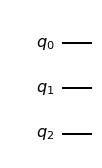

In [4]:
num_qubits = 3
qc = QuantumCircuit(num_qubits)
#draw circuit: most used method
qc.draw('mpl')

##draw circuit: text
#qc.draw(output='text')

##draw circuit: with style
#style = {'backgroundcolor': 'red'}
#qc.draw(output='mpl', style=style)

For more option and guide, please check this: https://qiskit.org/documentation/tutorials/circuits_advanced/03_advanced_circuit_visualization.html 

After you create the circuit with its quantum registers, you can add gates ("operations") to manipulate the registers. This time we will use a three-qubit GHZ state to understand how to use Qiskit to build a circuit and run.

$$|\psi\rangle = \left(|000\rangle+|111\rangle\right)/\sqrt{2}.$$

To create such a state, we start with a three-qubit quantum register. By default, each qubit in the register is initialized to $|0\rangle$ as we've already done above. To make the GHZ state, we apply the following gates:
* A Hadamard gate $H$ on qubit 0, which puts it into the superposition state $\left(|0\rangle+|1\rangle\right)/\sqrt{2}$.
* A controlled-Not operation ($C_{X}$) between qubit 0 and qubit 1.
* A controlled-Not operation between qubit 1 and qubit 2.

On an ideal quantum computer, the state produced by running this circuit would be the GHZ state above.

In Qiskit, operations can be added to the circuit one by one, as shown below.


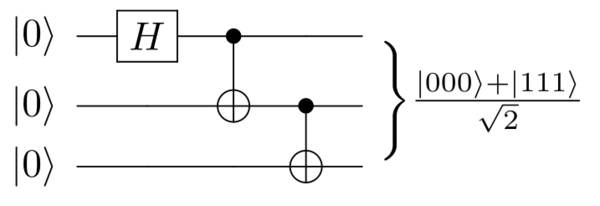

Let's compose this circuit by using quantum gates.

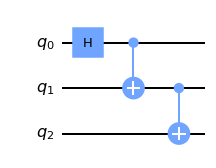

In [5]:
qc.h(0)
qc.cx(0,1)
qc.cx(1,2)
qc.draw('mpl')

## step2: Measure and visualize the GHZ circuit

If we want run the experiment on quantum hardware or a classical simulator emulating quantum hardware, we have to add a final measurement to the qubits to obtain information about the quantum state. The double line indicates a classical register where the number on top of the slash indicates how many classical registers we have. The k-th classical register will hold the measurement outcome of qubit k.

### Simulating circuits using Qiskit Aer  statevector backend "without measurement"<a name='simulation'></a>

Qiskit Aer is qiskit package for simulating quantum circuits. It provides many different backends for doing a simulation. The most common backend in Qiskit Aer is the `statevector_simulator`. This simulator returns the quantum 
state, which is a complex vector of dimensions $2^n$, where $n$ is the number of qubits 
(so be careful using this as it will quickly get too large to run on your machine).

From the measurement outcomes we can compute observables which are diagonal in the computational basis. Assuming $D=\mathrm{diag}(\lambda_0,\dots,\lambda_{2^N-1})$ we can calculate $\langle \psi |D|\psi\rangle$ by expanding the wave function in the computational basis, $|\psi\rangle = \sum_i c_i |i\rangle$:
$$\langle \psi |D|\psi\rangle = \sum_{i=0}^{2^N-1} |c_i|^2 \lambda_i.$$
Dividing the counts by the number of shots, we get an estimate for $|c_i|^2$.

For developing and debugging purposes, we frequently look at the state vector. While this cannot be done efficiently on a quantum computer, Qiskit offers the possibility to obtain the state vector using the `statevector_simulator` backend.

We can run this circuit on the state vector simulator to get the full wave function $|\psi\rangle$

In [6]:
from qiskit import Aer

# Run the quantum circuit on a statevector simulator backend
backend = Aer.get_backend('statevector_simulator')

Now that we have chosen the backend, it's time to compile and run the quantum circuit. In Qiskit we provide the `execute` function for this. ``execute`` returns a ``job`` object that encapsulates information about the job submitted to the backend.

In [7]:
# Create a Quantum Program for execution 
job = execute(qc, backend)

In [8]:
job = execute(qc, backend)
result = job.result()

counts = result.get_counts()
psi = result.get_statevector()

print('Total counts for the computational basis states:',counts)
print('|psi> =',psi)

Total counts for the computational basis states: {'000': 0.5, '111': 0.5}
|psi> = [ 0.70710678+0.j -0.        +0.j  0.        +0.j -0.        +0.j
  0.        +0.j -0.        +0.j  0.        +0.j  0.70710678+0.j]


### Simulating circuits using Qiskit Aer  statevector backend "with measurement"<a name='simulation'></a>
 
Note that we did __not__ add a measurement at the end of the circuit, as this would project the state vector to one of the basis state and the state vector simulator would only yield a single basis state (as you can see in the example below).

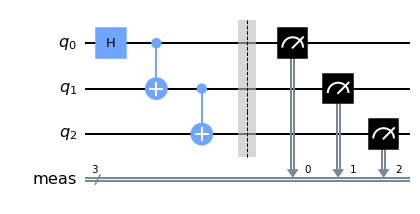

In [9]:
# Add a measurement to all qubits
qc.measure_all()
qc.draw('mpl')

In [10]:
job = execute(qc, backend, shots = 8192)

In [11]:
result = job.result()

counts = result.get_counts()
psi_with_measurement = result.get_statevector()
print('|psi_with_measurement> =',psi_with_measurement)
print('Total counts for the computational basis states:',counts)

|psi_with_measurement> = [ 1.+0.j -0.+0.j  0.+0.j -0.+0.j  0.+0.j -0.+0.j  0.+0.j  0.+0.j]
Total counts for the computational basis states: {'000': 4107, '111': 4085}


### Simulating circuits using Qiskit Aer  openqasm backend with measurement - local run<a name='simulation'></a>
<a name='simulation'></a>

Qiskit's openqasm simulator is a general-purpose simulator for simulating quantum circuits both ideally and subject to noise modeling. The simulation method is automatically selected based on the input circuits and parameters.

To simulate this circuit, we use the ``qasm_simulator`` in Qiskit Aer. Each run of this circuit will yield either the bitstring 000 or 111. To build up statistics about the distribution of the bitstrings (to, e.g., estimate $\mathrm{Pr}(000)$), we need to repeat the circuit many times. The number of times the circuit is repeated can be specified in the ``execute`` function, via the ``shots`` keyword.

In [12]:
# Generate a qasm_simulator backend which emulates a quantum computer
qasm_simulator = Aer.get_backend('qasm_simulator')

job = execute(qc, qasm_simulator, shots=8192)
result = job.result()

qasm_counts = result.get_counts()
print('Total counts for the computational basis states:',counts)

Total counts for the computational basis states: {'000': 4107, '111': 4085}


Approximately 50 percent of the time, the output bitstring is 000. Qiskit also provides a function `plot_histogram`, which allows you to view the outcomes. 

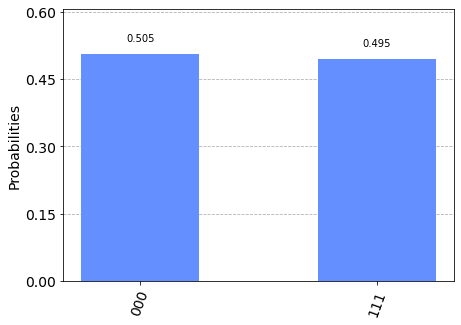

In [13]:
from qiskit.visualization import plot_histogram
plot_histogram(qasm_counts)

We can add a noise model to the qasmsimulator to mimic the noise configuration of the real backend.



Total counts for the computational basis states: {'101': 126, '100': 37, '001': 319, '110': 277, '111': 3580, '011': 87, '010': 52, '000': 3714}


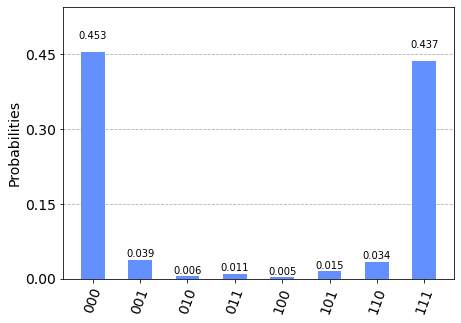

In [14]:
from qiskit.test.mock import FakeVigo
from qiskit.providers.aer.noise import NoiseModel

noisy_backend = FakeVigo() 

noise_model = NoiseModel.from_backend(noisy_backend)
coupling_map = noisy_backend.configuration().coupling_map

job = execute(qc, qasm_simulator, shots=8192, coupling_map=coupling_map, noise_model=noise_model)
result = job.result()

counts = result.get_counts()
print('Total counts for the computational basis states:',counts)

plot_histogram(counts)

### transpile

Before running a quantum circuit, every circuit needs to be transpiled to run onto the quantum backend. it includes:
1. decompose our circuit into the basis gate of the each backend
2. find a best qubit path to reduce the noise,
etc.

Let's take a glance at this transpiling simply with the one of the multi-qubit gate - CCX.

In [15]:
print(noisy_backend.configuration().basis_gates)
print(qasm_simulator.configuration().basis_gates)

['id', 'rz', 'sx', 'x', 'cx']
['ccx', 'cp', 'cswap', 'csx', 'cu', 'cu1', 'cu2', 'cu3', 'cx', 'cy', 'cz', 'delay', 'diagonal', 'h', 'id', 'initialize', 'mcp', 'mcphase', 'mcr', 'mcrx', 'mcry', 'mcrz', 'mcswap', 'mcsx', 'mcu', 'mcu1', 'mcu2', 'mcu3', 'mcx', 'mcx_gray', 'mcy', 'mcz', 'multiplexer', 'p', 'pauli', 'r', 'rx', 'rxx', 'ry', 'ryy', 'rz', 'rzx', 'rzz', 's', 'sdg', 'swap', 'sx', 'sxdg', 't', 'tdg', 'u', 'u1', 'u2', 'u3', 'unitary', 'x', 'y', 'z', 'kraus', 'roerror', 'save_amplitudes', 'save_amplitudes_sq', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'set_density_matrix', 'set_stabilizer', 'set_statevector', 'snapshot']


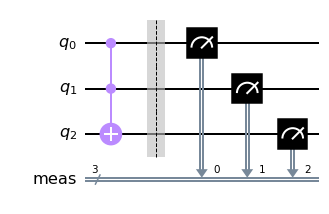

In [16]:
test_ccx = QuantumCircuit(3)
test_ccx.ccx(0,1,2)
test_ccx.measure_all()
test_ccx.draw('mpl')

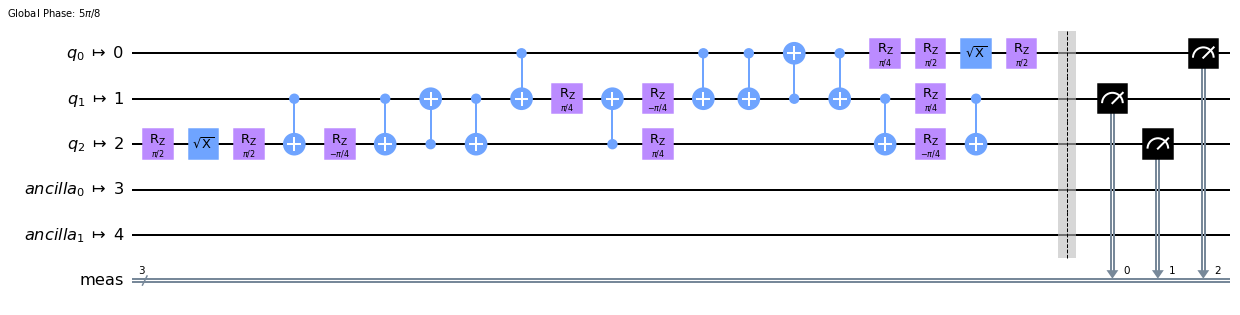

In [17]:
from qiskit import transpile
from qiskit.visualization import plot_circuit_layout


new_circ_lv0 = transpile(test_ccx, backend=noisy_backend, optimization_level=0)
new_circ_lv0.draw('mpl')

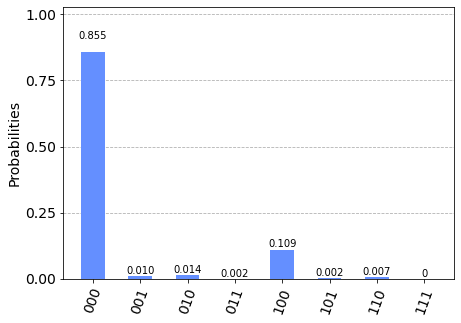

In [18]:
result = noisy_backend.run(new_circ_lv0, shots=8192).result()
counts = result.get_counts()
plot_histogram(counts)

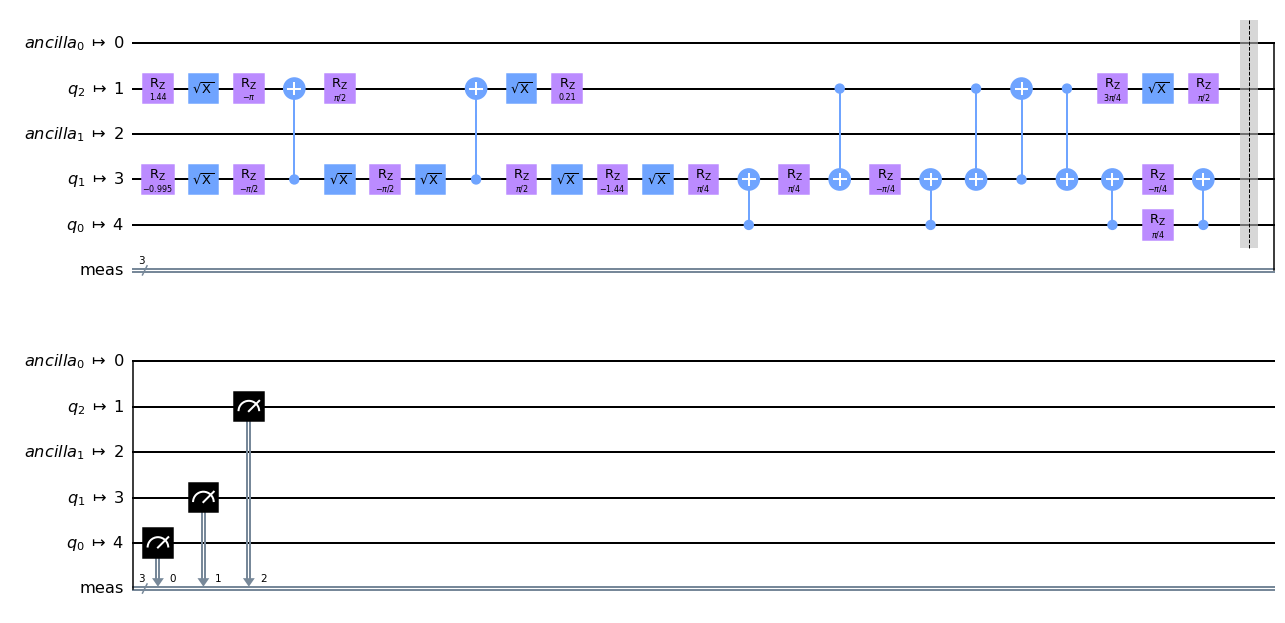

In [19]:
new_circ_lv3 = transpile(test_ccx, backend=noisy_backend, optimization_level=3)
new_circ_lv3.draw('mpl')

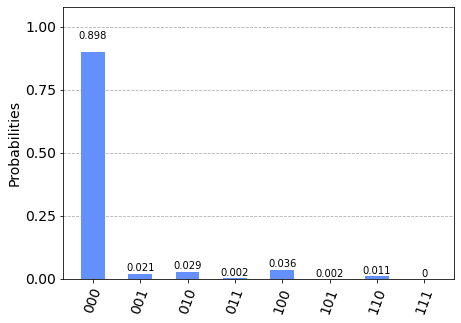

In [20]:
result = noisy_backend.run(new_circ_lv3, shots=8192).result()
counts = result.get_counts()
plot_histogram(counts)

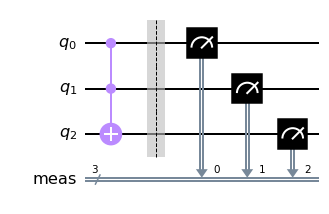

In [21]:
new_circ_qasm0 = transpile(test_ccx, backend=qasm_simulator, optimization_level=0)
new_circ_qasm0.draw('mpl')

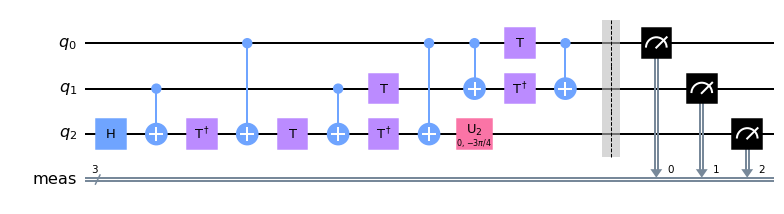

In [22]:
new_circ_qasm = transpile(test_ccx, backend=qasm_simulator, optimization_level=3)
new_circ_qasm.draw('mpl')

## Running circuits with the IBM Q account <a name='ibmq'></a>

To facilitate access to real quantum computing hardware, we have provided a simple API interface.
To access IBM Q devices, you'll need an API token. You can generate, or view, your API token [here](https://quantum-computing.ibm.com/account) (create an account if you don't already have one).

Your IBM Q account lets you run your circuit on real devices or on our cloud simulator. Basic account usage can be seen in the examples below. For more detailed instructions on using the IBM Q account, see [Part 3: The IBMQ Account](3_the_ibmq_account.ipynb).

In [24]:
from qiskit import IBMQ


After generating your API token, call: `IBMQ.save_account('MY_TOKEN')`.

This will store your IBM Q credentials in a local file.  Unless your registration information has changed, you only need to do this once.  You may now load your accounts by calling,

In [25]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

Once your account has been loaded, you have one or more providers available to you

In [26]:
IBMQ.providers()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-skku', group='snu', project='snu-graduate')>,
 <AccountProvider for IBMQ(hub='strangeworks-hub', group='qc-com', project='runtime')>,
 <AccountProvider for IBMQ(hub='iqc-africa-21-5', group='q-challenge-2', project='ex1-reckGeZVHsfYL0roi')>]

Each provider gives access to a selection of services (e.g. Backends) that is authorized by your account.  To see the backends available to a given provider, first select the provider by hub, group, project, or a combination thereof:

In [27]:
provider = IBMQ.get_provider(group='open')

then ask the provider to list its backends:

In [28]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_m

### Running circuits on real devices

Today's quantum information processors are small and noisy, but are advancing at a fast pace. They provide a great opportunity to explore what [noisy, intermediate-scale quantum (NISQ)](https://arxiv.org/abs/1801.00862) computers can do.

Let us now grab a backend from the provider on which to run our quantum circuit with least_busy function with filtering options to find a least_busy backend with more than 3 qubits and not a simulator

In [29]:
from qiskit.providers.ibmq import least_busy
q3devices = provider.backends(filters=lambda x: x.configuration().n_qubits > 3
                                   and not x.configuration().simulator)
backend = least_busy(q3devices)

In [30]:
from qiskit.tools.jupyter import *
backend

<IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>

To run the circuit on the given device we use `execute`.  Sometimes the devices are busy with jobs from other users.  Your job is added to the list of pending jobs called the queue, and executed in this queue order.  To monitor the status of our job through the process, we can use the `job_monitor`

In [31]:
from qiskit.tools.monitor import job_monitor

job_exp = execute(qc, backend=backend, optimization_level=3, shots=8192)
job_monitor(job_exp)

Job Status: job has successfully run


``job_exp`` has a ``.result()`` method that lets us get the results from running our circuit.

<div class="alert alert-block alert-info">
<b>Note:</b> When the .result() method is called, the code block will wait until the job has finished before releasing the cell.
</div>

In [33]:
job_id = '617179b74372735f0e98851b'

print('JOB ID: {}'.format(job_id))

JOB ID: 617179b74372735f0e98851b


In [35]:
result_exp = job_exp.result()
#result_exp = backend.retrieve_job(job_id)

Like before, the counts from the execution can be obtained using ```get_counts(qc)``` 

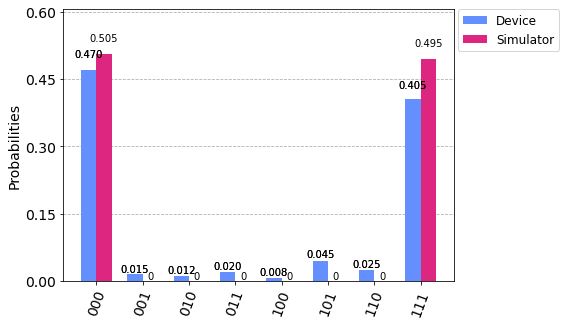

In [36]:
result_exp = job_exp.result()
counts_exp = result_exp.get_counts(qc)
plot_histogram([counts_exp,qasm_counts], legend=['Device', 'Simulator'])

### Simulating circuits using the IBM Q cloud simulator

The IBM Q provider also comes with a remote optimized simulator called ``ibmq_qasm_simulator``. This remote simulator is capable of simulating up to 32 qubits. It can be used the same way as the remote real backends. 

In [37]:
simulator_backend = provider.get_backend('ibmq_qasm_simulator')

In [38]:
job_cloud = execute(qc, backend=simulator_backend)
job_monitor(job_cloud)


Job Status: job has successfully run


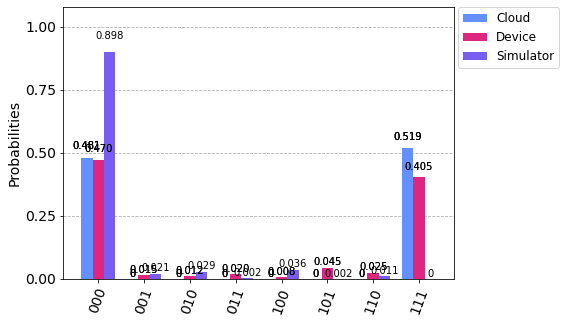

In [39]:
result_cloud = job_cloud.result()
counts_cloud = result_cloud.get_counts(qc)
plot_histogram([counts_cloud, counts_exp,counts], legend=['Cloud','Device', 'Simulator'])


### Retrieving a previously run job

If your experiment takes longer to run then you have time to wait around, or if you simply want to retrieve old jobs, the IBM Q backends allow you to do that.
First, you would need to note your job's ID:

In [40]:
job_id = job_exp.job_id()

print('JOB ID: {}'.format(job_id))

JOB ID: 617259111cc681c4109877ae


Given a job ID, that job object can be later reconstructed from the backend using ```retrieve_job```:

In [41]:
retrieved_job = backend.retrieve_job(job_id)

In [42]:
retrieved_job.result().get_counts(qc)

{'000': 3852,
 '001': 123,
 '010': 99,
 '011': 164,
 '100': 63,
 '101': 372,
 '110': 203,
 '111': 3316}

### Checking the fidelity
A good measure to check if two pure quantum states are the same is the fidelity
$$F(|\psi_1\rangle, |\psi_2\rangle) = |\langle\psi_1|\psi_2\rangle|^2$$
which is 0 iff $|\psi_1\rangle \bot |\psi_2\rangle$ and 1 iff $|\psi_1\rangle = |\psi_2\rangle$ up to a global phase. 

In [43]:
print('F(|psi>, |psi>) =',state_fidelity(psi,psi))
print('F(|psi>, |psi_with_measurement>) =',state_fidelity(psi,psi_with_measurement))


F(|psi>, |psi>) = 1.0
F(|psi>, |psi_with_measurement>) = 0.5000000000000001


### Visualizing the results from the state vector simulator
The density matrix $\rho = |\psi\rangle\langle\psi|$ can be visualized in various ways as shown in the following.

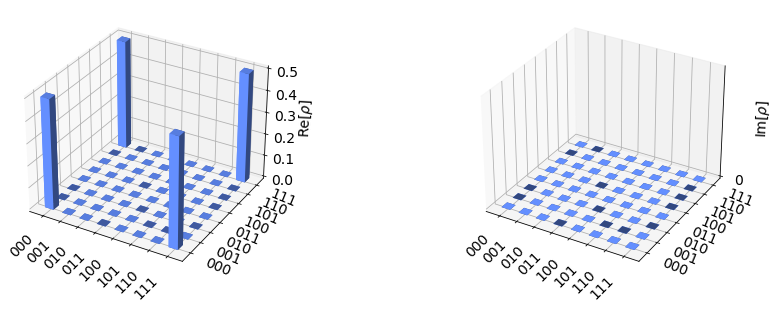

In [44]:
# Plot the real and imaginary parts of the density matrix
plot_state_city(psi)

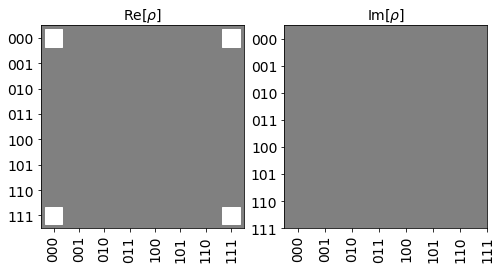

In [45]:
# Plot a 2d projection of the real and imaginary part of the density matrix
plot_state_hinton(psi)

Plot the expansion of the density matrix in the Pauli basis
$$\rho = \sum_{A,B=\{I,X,Y,Z\}}c_{AB}A\otimes B.$$

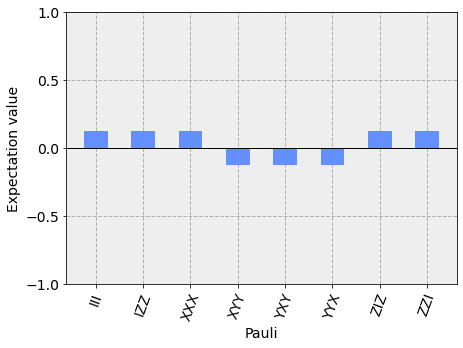

In [46]:
plot_state_paulivec(psi)

It is also possible to visualize the result on the Bloch sphere with `plot_bloch_multivector`. If the multi-qubit state is entangled, the reduced density matrix obtained after taking the partial trace over all qubits other than qubit $q$ is plotted for all of the qubits.

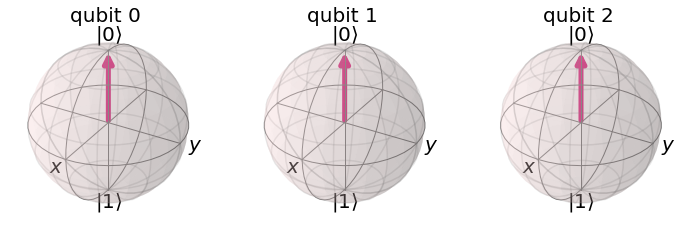

In [47]:
plot_bloch_multivector(psi_with_measurement)

In [51]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

Qiskit Software,Version
qiskit-terra,0.18.3
qiskit-aer,0.9.1
qiskit-ignis,0.6.0
qiskit-ibmq-provider,0.17.0
qiskit-aqua,0.9.5
qiskit,0.31.0
qiskit-nature,0.2.2
qiskit-finance,0.2.1
qiskit-optimization,0.2.3
qiskit-machine-learning,0.2.1
